# Постановка задачи

Дан массив данных, где хранятся 83 признаков разных компаний. Задача - прогнозирование банкротства компании. Будут использованы следующие методы:
* **Случайный лес**


* **Логистическая регрессия**


* **XGBoost**

## Описание данных

* **Первый столбец** `Company` - номера компаний.


* **Второй столбец**: `time` - различные периоды времени, к которым принадлежат данные. Длина временного ряда варьируется от `1 до 14` для **каждой** компании.


* **Третья колонка**: целевая переменная обозначается как `Financial Distress`, если она больше `-0.50`, то компания должна считаться `блаполучной (0)`. В противном случае компания будет рассматриваться как финансово `неблагополучный (1)`.


* **С четвертго по последний столбец**: признаки, обозначенные от `x1 до x83` , представляют собой некоторые финансовые характеристики компаний. Эти признаки полученные из прошлого, которые должны использоваться для прогнозирования банкротства. Признак `x80` является категориальной переменной.

# Обзор данных


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data = pd.read_csv('Financial Distress.csv')

### Проверка на наличие пропусков:

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 86 columns):
Company               3672 non-null int64
Time                  3672 non-null int64
Financial Distress    3672 non-null float64
x1                    3672 non-null float64
x2                    3672 non-null float64
x3                    3672 non-null float64
x4                    3672 non-null float64
x5                    3672 non-null float64
x6                    3672 non-null float64
x7                    3672 non-null float64
x8                    3672 non-null float64
x9                    3672 non-null float64
x10                   3672 non-null float64
x11                   3672 non-null float64
x12                   3672 non-null float64
x13                   3672 non-null float64
x14                   3672 non-null float64
x15                   3672 non-null float64
x16                   3672 non-null float64
x17                   3672 non-null float64
x18              

## Один из признаков является категориальным
Посмотрим на него подбробнее

In [20]:
categories = data['x80'].unique()
print(categories)
print(len(categories))

[22 29 25 12 23  9 28 14 11 18 26 21  3 20 15  7 24 19 27  1  4 17  6  8
  5  2 16 13 10 30 31 32 34 35 36 33 37]
37


Есть всего 37 уникальных значений признака 'x80'.

## Построим матрицу корелляции признаков

In [21]:
data_corr = data.drop(labels=['Company'], axis=1).corr()
data_corr = data_corr.sort_values(ascending=False, axis=1, by='Financial Distress')
data_corr.head(10)

,Financial Distress,x81,x48,x25,x10,x5,x2,x53,x9,x51,...,x14,x3,x71,x79,x73,x62,x63,x50,x61,x64
Time,0.144200,0.170792,0.125236,0.047027,0.337162,-0.005669,-0.001065,-0.004674,-0.192999,0.405762,...,-0.130468,-0.259707,-0.412424,-0.196859,-0.648888,-0.748330,-0.191402,-0.017868,-0.659081,-0.884338
Financial Distress,1.000000,0.442916,0.435318,0.376786,0.338298,0.274435,0.272978,0.245600,0.219091,0.191357,...,-0.078073,-0.089264,-0.089890,-0.116661,-0.134600,-0.143793,-0.150362,-0.155569,-0.157380,-0.173126
x1,0.030928,0.053595,0.039251,0.043398,0.296670,0.109543,0.208851,0.101277,-0.000506,-0.067987,...,-0.223763,-0.440321,-0.020399,-0.045919,-0.040829,-0.078965,-0.014623,-0.163607,-0.067027,-0.107117
x2,0.272978,0.281884,0.249237,0.483282,0.735503,0.892480,1.000000,0.798938,0.729858,0.197861,...,-0.397435,-0.504509,0.032094,-0.104102,0.052388,-0.001604,-0.069930,-0.638515,-0.023174,-0.026297
x3,-0.089264,-0.111055,-0.092989,-0.083522,-0.661908,-0.356252,-0.504509,-0.296368,-0.030976,0.019216,...,0.759448,1.000000,0.111871,0.102163,0.184080,0.183966,0.075016,0.415127,0.163390,0.222393
x4,0.116837,0.203058,0.201250,0.225023,0.064635,0.194218,0.114046,0.315602,0.135739,0.320267,...,0.035727,0.094481,0.000471,-0.044051,-0.003886,-0.047514,-0.029564,0.305579,-0.047630,-0.059740
x5,0.274435,0.266739,0.237494,0.461038,0.645829,1.000000,0.892480,0.906145,0.687468,0.236526,...,-0.297055,-0.356252,0.019983,-0.120217,0.035566,-0.008896,-0.094203,-0.624459,-0.036667,-0.025415
x6,0.077260,0.101647,0.083978,0.076557,0.441091,0.236113,0.298078,0.255941,0.005126,-0.096300,...,-0.435001,-0.593620,-0.051343,-0.084758,-0.075941,-0.113815,-0.045330,-0.188840,-0.101086,-0.136648
x7,0.042412,0.064812,0.050854,0.061415,0.290069,0.110410,0.214098,0.092646,0.019448,-0.037694,...,-0.191658,-0.398730,-0.036066,-0.017951,-0.057026,-0.085511,-0.002137,-0.172219,-0.067887,-0.111500
x8,-0.006382,-0.000214,-0.001069,0.001520,0.007163,-0.011965,0.014020,-0.014444,0.028458,-0.066608,...,-0.006725,-0.006290,-0.007050,0.036357,-0.000466,0.002513,0.015077,0.014445,0.009484,0.009862


## И отобразим ее на карте

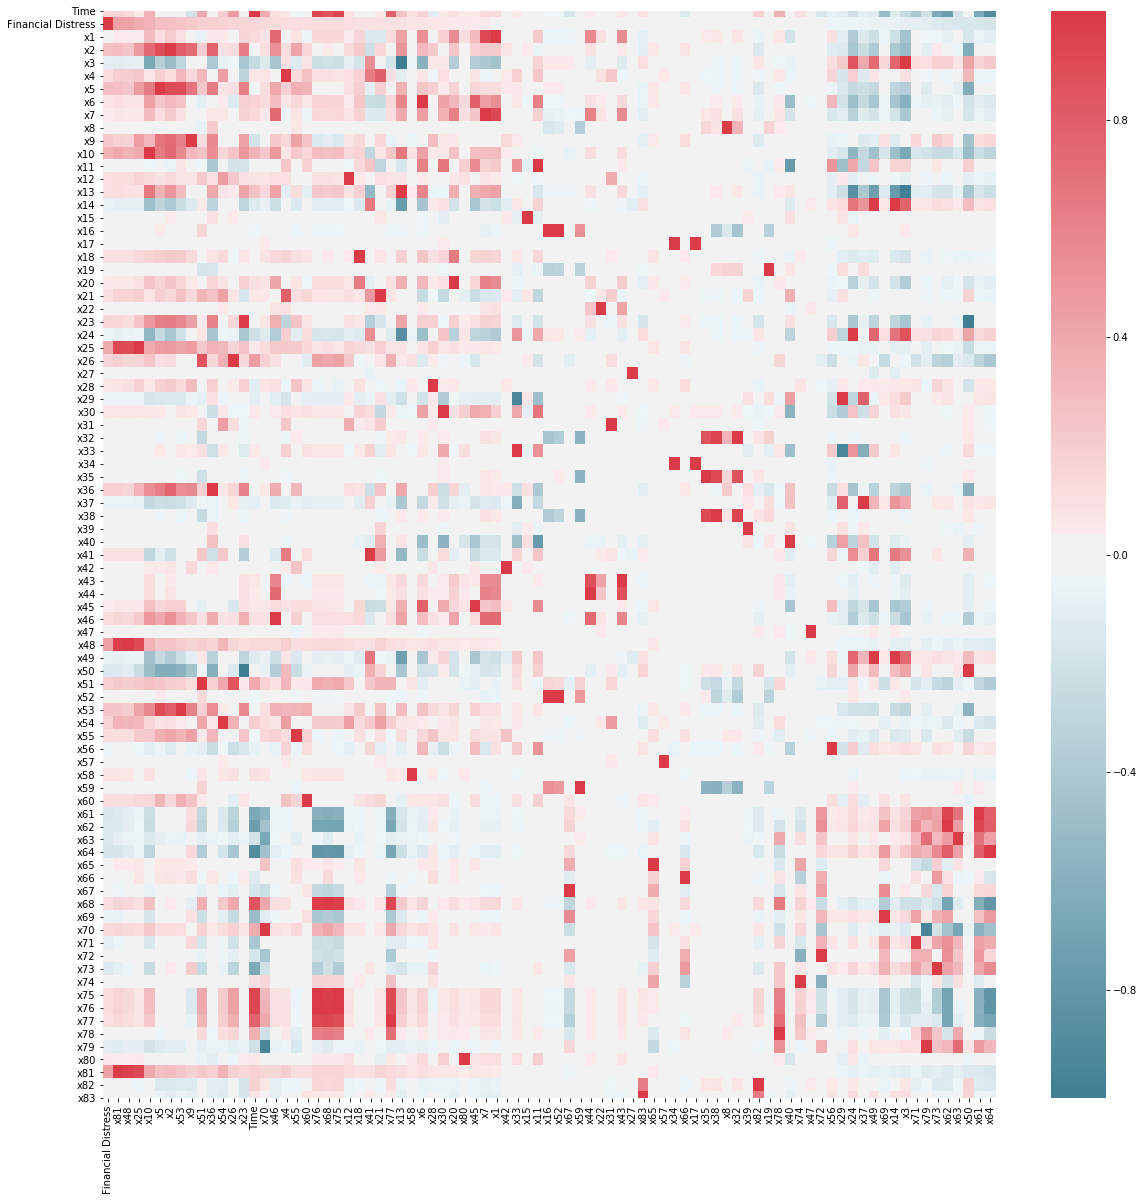

In [22]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize = (20,20))
sns.heatmap(data_corr, cmap=cmap)

Видим, что наблюдается достаточно большая корреляция между признаками и Financial Distress (чем краснее, тем больше корреляция, связь)

## Создаем вектор ответов для классификации
Компании с уровнем Financial Distress не более -0.5 являются неблагополучными. Поставим задачу как задачу классификации.

In [23]:
distressed = [1 if row['Financial Distress'] <= -0.5 else 0 for _, row in data.iterrows()]
data_full = data
data_full['Distressed'] = pd.Series(distressed)

## Разделим данные на обучающую и тестовую выборку.
Обучающая выборка будет использоваться для кросс-валидации и настройки гиперпараметров.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

In [25]:
SSS = StratifiedShuffleSplit(random_state=10, test_size=.3, n_splits=1)
X = data_full.iloc[:, 3:-1].drop('x80', axis=1)
y = data_full['Distressed'] 
for train_index, test_index in SSS.split(X, y):
    print("CV:", train_index, "HO:", test_index)
    X_cv, X_ho = X.iloc[train_index], X.iloc[test_index]

CV: [3386 1214 2525 ... 2416  634 2924] HO: [2474 1786 1337 ... 3543 2556 1521]


## Классы очень несбалансированы

Имеются 3536 временных записей, когда компании находились в неблагополучном состоянии и только 136 блаполочных

In [27]:
data_full['Distressed'].value_counts()

0    3536
1     136
Name: Distressed, dtype: int64

In [28]:
136/3536

0.038461538461538464

## Первую серию моделей будем строить для несбалансированных классов без дополнительного feature engineering

Пробуем провести классификацию, не проведя дополнительных манипуляций с данными (что будет рассмотрено ниже)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint

## Случайный лес

Набираем параметры классификатора: (минимальное число листов в деревьях, минимальное число успешных классификаций, чтобы можно было далее делить и т.д.)

In [80]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 55, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
class_weight = ['balanced', None]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}

Проводим рандомный перебор данных, чтобы выявить наиболее подходящие параметры

In [81]:
rf_clsf = RandomForestClassifier(random_state=10, class_weight='balanced')
rf_random = RandomizedSearchCV(estimator = rf_clsf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=10, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
rf_random.fit(X_cv, y_cv)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

### Находим точность классификации

In [82]:
print(rf_random.best_score_)

0.37831701433234


In [83]:
best_rf_clsf = rf_random.best_estimator_
best_rf_clsf.fit(X_cv, y_cv)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=412,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

### Находим метрики: `Полноту`, `Точность` и `F меру`

In [84]:
print(recall_score(y_ho, best_rf_clsf.predict(X_ho)),
      precision_score(y_ho, best_rf_clsf.predict(X_ho)),
      f1_score(y_ho, best_rf_clsf.predict(X_ho)))

0.6097560975609756 0.3424657534246575 0.43859649122807015


## Логистическая регрессия

In [74]:
lr_penalty = ['l1']
lr_class_weight = ['balanced', None]
lr_C = [0.001, 0.01, 0.1, 1, 10]

lr_solver = ['liblinear', 'saga']

lr_grid = {'penalty': lr_penalty,
           'class_weight': lr_class_weight,
           'C': lr_C,
           #'max_iter': lr_max_iter,
           'solver': lr_solver}

In [75]:
lr_clsf = LogisticRegression(random_state=10, max_iter=100)
lr_grid = GridSearchCV(estimator = lr_clsf, param_grid = lr_grid, cv = 3, verbose=2, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
lr_grid.fit(X_cv, y_cv)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.6s finished
C:\Users\SerPetr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', None], 'penalty': ['l1'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 'precision', 'recall'], verbose=2)

### Находим точность классификации

In [77]:
lr_grid.best_score_

0.3075985539679807

In [78]:
best_lr_clsf = lr_grid.best_estimator_
best_lr_clsf.fit(X_cv, y_cv)

C:\Users\SerPetr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=10, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Находим метрики: `Полноту`, `Точность` и `F меру`

In [79]:
print(recall_score(y_ho, best_lr_clsf.predict(X_ho)),
      precision_score(y_ho, best_lr_clsf.predict(X_ho)),
      f1_score(y_ho, best_lr_clsf.predict(X_ho)))

0.8536585365853658 0.16908212560386474 0.28225806451612906


## XGBoost

In [42]:
xgb_learning_rate = [x for x in np.linspace(start = 0.001, stop = 0.1, num = 10)]
xgb_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
xgb_booster = ['gbtree', 'dart']
xgb_colsample_bytree = [0.4, 0.6, 0.8, 1.0]
xgb_colsample_bylevel = [0.5, 0.75, 1.0]
xgb_scale_pos_weight = [(len(y_cv) - sum(y_cv))/sum(y_cv)]
xgb_min_child_weight = [1]
xgb_subsample = [0.5, 1.0]


random_grid = {'learning_rate': xgb_learning_rate,
               'n_estimators': xgb_n_estimators,
               'booster': xgb_booster,
               'colsample_bytree': xgb_colsample_bytree,
               'colsample_bylevel': xgb_colsample_bylevel,
               'scale_pos_weight': xgb_scale_pos_weight,
               'min_child_weight': xgb_min_child_weight,
               'subsample': xgb_subsample}

In [43]:
xgb_clsf = xgb.XGBClassifier(random_state=10)
xgb_random = RandomizedSearchCV(estimator = xgb_clsf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=10, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
xgb_random.fit(X_cv, y_cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=10, reg_alpha=0,
                                           reg_lambda=1, s...
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                  

### Находим точность классификации

In [44]:
xgb_random.best_score_

0.4041610233008916

In [45]:
best_xgb_clsf = xgb_random.best_estimator_
best_xgb_clsf.fit(X_cv, y_cv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.023000000000000003, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26.05263157894737,
              seed=None, silent=None, subsample=0.5, verbosity=1)

### Находим метрики: `Полноту`, `Точность` и `F меру`

In [46]:
print(recall_score(y_ho, best_xgb_clsf.predict(X_ho)),
      precision_score(y_ho, best_xgb_clsf.predict(X_ho)),
      f1_score(y_ho, best_xgb_clsf.predict(X_ho)))

0.7317073170731707 0.22900763358778625 0.3488372093023256


## Вторая серия моделей

Для второй серии моделей кодируем категориальный признак, прошкалируем данные

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

In [49]:
X = data_full.iloc[:, 3:-1]
y = data_full['Distressed'] 

In [50]:
X_encoded = pd.get_dummies(X, columns=['x80'], prefix='x80_')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_scaled = pd.DataFrame(X_scaled, index=X_encoded.index, columns=X_encoded.columns)
for train_index, test_index in SSS.split(X_scaled, y):
    print("CV:", train_index, "HO:", test_index)
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_sample(X_train, y_train)

CV: [3386 1214 2525 ... 2416  634 2924] HO: [2474 1786 1337 ... 3543 2556 1521]


In [51]:
y_test

2474    0
1786    1
1337    0
2935    0
1446    0
       ..
367     0
2456    0
3543    0
2556    0
1521    0
Name: Distressed, Length: 1102, dtype: int64

## Случайный лес после обработки признаков

In [52]:
rf_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
rf_max_features = ['auto', 'sqrt']
rf_max_depth = [int(x) for x in np.linspace(50, 100, num = 10)]
rf_max_depth.append(None)
rf_min_samples_split = [2, 5, 10]
rf_min_samples_leaf = [1, 2, 3, 4]
rf_bootstrap = [True, False]
rf_class_weight = ['balanced', None]

rf_random_grid = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'max_depth': rf_max_depth,
               'min_samples_split': rf_min_samples_split,
               'min_samples_leaf': rf_min_samples_leaf,
               'bootstrap': rf_bootstrap,
               'class_weight': rf_class_weight}

In [53]:
rf_clsf = RandomForestClassifier(random_state=10)
rf_random_2 = RandomizedSearchCV(estimator = rf_clsf, param_distributions = rf_random_grid, n_iter = 10, cv = 3, verbose=2, random_state=10, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
rf_random_2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.8s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [54]:
best_rf_clsf = rf_random_2.best_estimator_
best_rf_clsf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

### Находим точность классификации и метрики: `Полноту`, `Точность` и `F меру`
#### Было:
0.37831701433234


0.6097560975609756 0.3424657534246575 0.43859649122807015

#### Стало:

In [66]:
print(rf_random_2.best_score_)
print(recall_score(y_test, best_rf_clsf.predict(X_test)),
      precision_score(y_test, best_rf_clsf.predict(X_test)),
      f1_score(y_test, best_rf_clsf.predict(X_test)))

0.9818757902921966
0.36585365853658536 0.32608695652173914 0.3448275862068966


## Логистическая регрессия после обработки признаков

In [56]:
lr_penalty = ['l1', 'l2']
lr_class_weight = ['balanced', None]
lr_C = [0.1, 1, 10, 100]
lr_solver = ['liblinear', 'saga']

lr_grid = {'penalty': lr_penalty,
           'class_weight': lr_class_weight,
           'C': lr_C,
           'solver': lr_solver}

In [57]:
lr_clsf = LogisticRegression(random_state=10, max_iter=1000)
lr_grid_2 = GridSearchCV(estimator = lr_clsf, param_grid = lr_grid, cv = 3, verbose=2, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
lr_grid_2.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['f1', 'precision', 'recall'], verbose=

In [58]:
best_lr_clsf = lr_grid_2.best_estimator_
best_lr_clsf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=10, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Находим точность классификации и метрики: `Полноту`, `Точность` и `F меру`

#### Было:

0.3075985539679807


0.8536585365853658 0.16908212560386474 0.28225806451612906

#### Стало:

In [72]:
print(lr_grid_2.best_score_)
print(recall_score(y_test, best_lr_clsf.predict(X_test)),
      precision_score(y_test, best_lr_clsf.predict(X_test)),
      f1_score(y_test, best_lr_clsf.predict(X_test)))

0.9393676602654103
0.7804878048780488 0.18497109826589594 0.2990654205607477


## XGBoost после обработки признаков

In [60]:
xgb_learning_rate = [x for x in np.linspace(start = 0.001, stop = 0.1, num = 10)]
xgb_n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
xgb_booster = ['gbtree', 'dart']
xgb_colsample_bytree = [0.4, 0.6, 0.8, 1.0]
xgb_colsample_bylevel = [0.5, 0.75, 1.0]
xgb_scale_pos_weight = [(len(y_cv) - sum(y_cv))/sum(y_cv)]
xgb_min_child_weight = [1]
xgb_subsample = [0.5, 1.0]


random_grid = {'learning_rate': xgb_learning_rate,
               'n_estimators': xgb_n_estimators,
               'booster': xgb_booster,
               'colsample_bytree': xgb_colsample_bytree,
               'colsample_bylevel': xgb_colsample_bylevel,
               'scale_pos_weight': xgb_scale_pos_weight,
               'min_child_weight': xgb_min_child_weight,
               'subsample': xgb_subsample}

In [61]:
xgb_clsf = xgb.XGBClassifier(random_state=10)
xgb_random_2 = RandomizedSearchCV(estimator = xgb_clsf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=10, n_jobs = -1, refit='f1', scoring=['f1', 'precision', 'recall'])
xgb_random_2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=10, reg_alpha=0,
                                           reg_lambda=1, s...
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                  

In [62]:
best_xgb_clsf = xgb_random_2.best_estimator_
best_xgb_clsf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.07800000000000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=26.05263157894737,
              seed=None, silent=None, subsample=1.0, verbosity=1)

### Находим точность классификации и метрики: `Полноту`, `Точность` и `F меру`
#### Было:

0.4041610233008916


0.7317073170731707 0.22900763358778625 0.3488372093023256

#### Стало:

In [85]:
print(xgb_random_2.best_score_)
print(recall_score(y_test, best_xgb_clsf.predict(X_test)),
      precision_score(y_test, best_xgb_clsf.predict(X_test)),
      f1_score(y_test, best_xgb_clsf.predict(X_test)))

0.9707335544937843
0.5365853658536586 0.23157894736842105 0.32352941176470584


# Вывод

После нормализации признаков в данных, методы начали лучше классифицировать (возможно переобучение) банкротство компаний, но при этом в трех методах упала полнота (способность алгоритма обнаруживать банкротство), точность (способность отличать банкротство от не банкротства), немного увеличилась (хотя и была низкой) точность Регрессии и  XGBoost'a. Что и отражается на F меру, который является средним гармоническим precision и recall.